<a href="https://colab.research.google.com/github/uruba24/Pneumonia-Detection-from-Chest-X-ray/blob/main/Pneumonia_Detection_from_Chest_X_ray_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uroobaaftab","key":"e6d98caa38deaeeffece24c09cbd493f"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model


In [6]:
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"


In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


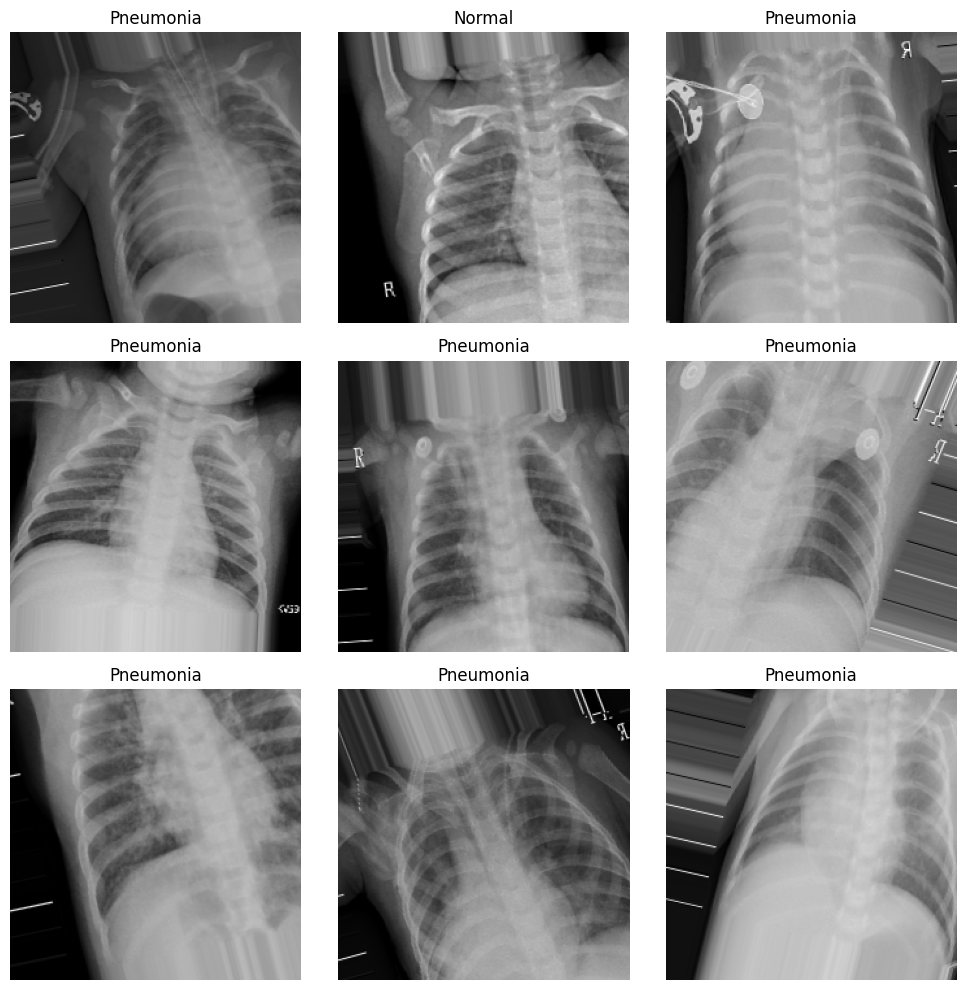

In [8]:
def plot_images(generator):
    images, labels = next(generator)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title("Pneumonia" if labels[i] == 1 else "Normal")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_images(train_generator)


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)
model.save("pneumonia_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 635ms/step - accuracy: 0.6800 - loss: 2.6489 - val_accuracy: 0.5000 - val_loss: 0.6678
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 598ms/step - accuracy: 0.7402 - loss: 0.5056 - val_accuracy: 0.5000 - val_loss: 0.7606
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 592ms/step - accuracy: 0.7455 - loss: 0.4602 - val_accuracy: 0.5000 - val_loss: 0.7030
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 599ms/step - accuracy: 0.7453 - loss: 0.4861 - val_accuracy: 0.5000 - val_loss: 0.7534
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 588ms/step - accuracy: 0.7501 - loss: 0.4402 - val_accuracy: 0.5000 - val_loss: 1.0366
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 595ms/step - accuracy: 0.7444 - loss: 0.4490 - val_accuracy: 0.5000 - val_loss: 0.9597
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 595ms/step - accuracy: 0.7453 - loss: 0.4879 - val_accuracy: 0.5000 - val_loss: 1.0112
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 588ms/step - accuracy: 0.7420 - lo

In [13]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.6011 - loss: 0.5229
Test Accuracy: 62.01%


In [14]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [15]:

history_finetuned = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 608ms/step - accuracy: 0.7394 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 5.3189
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 599ms/step - accuracy: 0.8279 - loss: 0.3635 - val_accuracy: 0.5000 - val_loss: 3.7834
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 595ms/step - accuracy: 0.8524 - loss: 0.3216 - val_accuracy: 0.5625 - val_loss: 1.6895
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.8558 - loss: 0.3090 - val_accuracy: 0.6250 - val_loss: 1.8654
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 604ms/step - accuracy: 0.8742 - loss: 0.2885 - val_accuracy: 0.6250 - val_loss: 0.8947


In [16]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.7784 - loss: 0.4784
Test Accuracy: 78.29%
Test Loss: 46.37%


<ipython-input-17-b4aec2c4a552>:31: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-17-b4aec2c4a552>:45: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


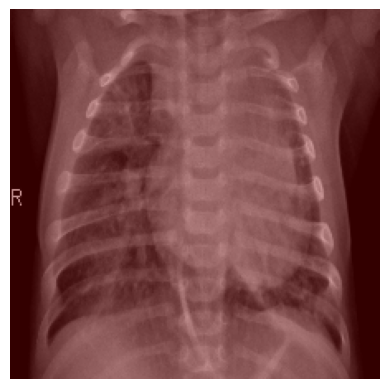

In [17]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


def grad_cam(model, img_array, class_idx):
    last_conv_layer = model.get_layer("conv5_block3_out")

    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        tape.watch(last_conv_layer_output)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(last_conv_layer_output.shape[-1]):
        last_conv_layer_output[..., i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def display_grad_cam(img_path, model, class_idx):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = grad_cam(model, img_array, class_idx)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    heatmap = np.uint8(255 * heatmap)
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    superimposed_img = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

img_path = "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
display_grad_cam(img_path, model, class_idx=1)


In [18]:
pip install streamlit tensorflow opencv-python matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [19]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


model = load_model("pneumonia_model.h5")


def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def grad_cam(model, img_array):
    last_conv_layer = model.get_layer("conv5_block3_out")
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output.numpy()[0]

    for i in range(conv_output.shape[-1]):
        conv_output[..., i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img, heatmap):
    heatmap = np.uint8(255 * heatmap)
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)
    return superimposed_img

st.title("Pneumonia Detection from Chest X-rays")
st.write("Upload a chest X-ray image, and the model will predict if it's **Normal** or **Pneumonia**.")

uploaded_file = st.file_uploader("Upload an X-ray Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_array = preprocess_image(img_rgb)

    prediction = model.predict(img_array)
    result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
    confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

    st.image(img_rgb, caption="Uploaded X-ray", use_column_width=True)
    st.write(f"### Prediction: **{result}**")
    st.write(f"Confidence: {confidence:.2%}")

    heatmap = grad_cam(model, img_array)
    heatmap_img = overlay_heatmap(img_rgb, heatmap)

    st.image(heatmap_img, caption="Grad-CAM Heatmap", use_column_width=True)


Writing app.py


In [20]:
!pip install pyngrok

In [23]:
from pyngrok import ngrok
ngrok.set_auth_token("2rRS9CabxcpLQSLlp8q43YVTZck_5Tb8ZycAuMYQ84pwB3eG4")

In [24]:
!streamlit run app.py &>/dev/null &

public_url = ngrok.connect(addr=8501)
print("Streamlit app is running at:", public_url)


Streamlit app is running at: NgrokTunnel: "https://f97a-34-142-225-59.ngrok-free.app" -> "http://localhost:8501"
